In [ ]:
https://github.com/heartcored98/Standalone-DeepLearning/blob/master/Lec2/Lab3_pytorch_classification_demo.ipynb

In [ ]:
# 출처 : 딥러닝 홀로서기
!pip install -q torch==1.0.0 torchvision
import torch
print(torch.__version__)

ERROR: Could not find a version that satisfies the requirement torch==1.0.0 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1)
ERROR: No matching distribution found for torch==1.0.0
2.0.1+cu118


Text(0.5, 1.0, 'Test Set Distribution')

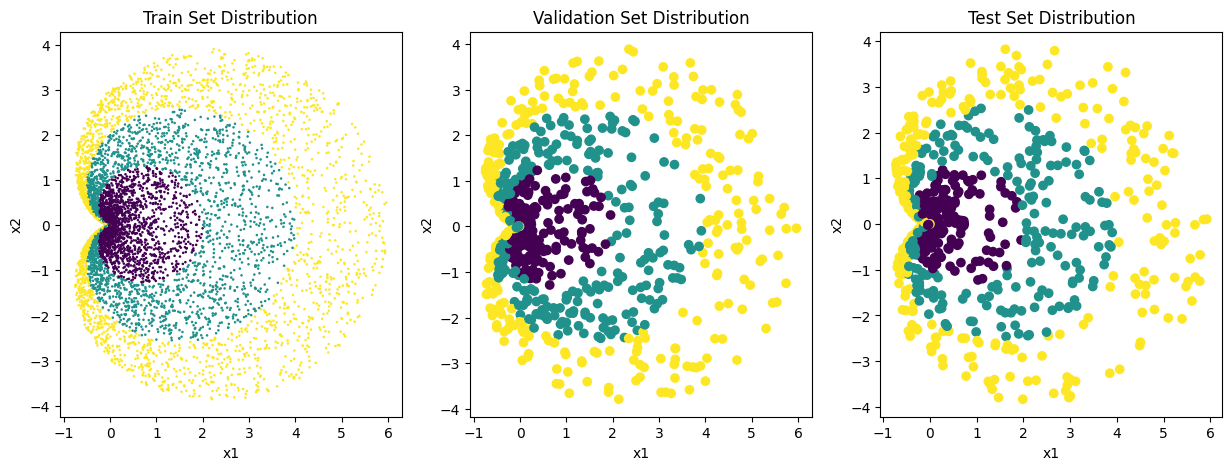

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt


# ====== Generating Dataset ====== #
r = np.random.rand(10000)*3
theta = np.random.rand(10000)*2*np.pi
y = r.astype(int)
r = r * (np.cos(theta) + 1)
x1 = r * np.cos(theta)
x2 = r * np.sin(theta)
X = np.array([x1, x2]).T

# ====== Split Dataset into Train, Validation, Test ======#
train_X, train_y = X[:8000, :], y[:8000]
val_X, val_y = X[8000:9000, :], y[8000:9000]
test_X, test_y = X[9000:, :], y[9000:]

# ====== Visualize Each Dataset ====== #
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(train_X[:, 0], train_X[:, 1], c=train_y, s=0.7)
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_title('Train Set Distribution')


ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(val_X[:, 0], val_X[:, 1], c=val_y)
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_title('Validation Set Distribution')

ax3 = fig.add_subplot(1, 3, 3)
ax3.scatter(test_X[:, 0], test_X[:, 1], c=test_y)
ax3.set_xlabel('x1')
ax3.set_ylabel('x2')
ax3.set_title('Test Set Distribution')


plt.show()

**Multi-Label Logistic Model**   
$$z = \ XW + b \ \ ( W \in \mathcal{R}^{2 \times 3}, b \in \mathcal{R}^{3}, z \in \mathcal{R}^{N \times 3}$$  
$$H = \ softmax(z) \ \ (  H \in \mathcal{R}^{N \times 3})$$  


**MLP Model**
$$Let \ relu(X) = \ max(X, 0)$$  

$$h = \ relu(X W_1 + b_1) \ \  ( W_1 \in \mathcal{R}^{2 \times 200}, b_1 \in \mathcal{R}^{200}, h \in \mathcal{R}^{N \times 200}$$  

$$z = \ h W_2 + b_2  \ \  ( W_2 \in \mathcal{R}^{200 \times 3}, b_2 \in \mathcal{R}^{3}, z \in \mathcal{R}^{N  \times 3})$$  

$$H = \ softmax(z) \ \ ( H \in \mathcal{R}^{N \times 3})$$  

In [ ]:
import torch
import torch.nn as nn


class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=2, out_features=3, bias=True)

    def forward(self, x):
        x = self.linear(x)
        return x

In [ ]:
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=200)
        self.linear2 = nn.Linear(in_features=200, out_features=3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

In [ ]:
cls_loss = nn.CrossEntropyLoss()

# Cross Entropy test
test_pred_y = torch.Tensor([[2,0.1],[0,1]])
test_true_y1 = torch.Tensor([1,0]).long()
test_true_y2 = torch.Tensor([0,1]).long()

print(cls_loss(test_pred_y, test_true_y1))
print(cls_loss(test_pred_y, test_true_y2))

tensor(1.6763)
tensor(0.2263)



accuracy_score Documentation : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
  
  
$$ Accuracy = \frac{Number \ of \ correct \ prediction}{Total \ number \ of \ predictions \ made} $$

In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

# ====== Construct Model ====== #
# model = LinearModel()
# print(model.linear.weight)
# print(model.linear.bias)

model = MLPModel() # Model을 생성해줍니다.
print('{} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad))) # 복잡해보이지만 간단히 모델 내에 학습을 당할 파라미터 수를 카운팅하는 코드입니다.

# ===== Construct Optimizer ====== #
lr = 0.005 # Learning Rate를 하나 정해줍니다. (원할한 학습을 위해 손을 많이 탑니다)
optimizer = optim.SGD(model.parameters(), lr=lr) # Optimizer를 생성해줍니다.

# 매 학습 단계에서의 epoch값과 그 때의 loss 값을 저장할 리스트를 만들어줍시다.
list_epoch = []
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []

epoch = 4000 # 학습 횟수(epoch)을 지정해줍시다.
for i in range(epoch):
    # ====== Train ====== #
    model.train() # model을 train 모드로 세팅합니다. 반대로 향후 모델을 평가할 때는 eval() 모드로 변경할 겁니다 (나중 실습에서 쓸 겁니다)
    optimizer.zero_grad() # optimizer에 남아있을 수도 있는 잔여 그라디언트를 0으로 다 초기화해줍니다.

    input_x = torch.Tensor(train_X)
    true_y = torch.Tensor(train_y).long()
    pred_y = model(input_x)
    #print(input_x.shape, true_y.shape, pred_y.shape) # 각 인풋과 아웃풋의 차원을 체크해봅니다

1203 parameters
